In [2]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
def select_columns(df, metrics, windows):
    selected_columns = [
        col for col in df.columns
        if any(metric in col for metric in metrics) and any(f"_{window}" in col for window in windows)
    ]
    return df[selected_columns]

windows = [30]
metrics = [
    'Realized_Volatility', 'Garman_Klass_Volatility', 'OU_Theta', 'Hurst', 'Momentum', 'RSI', 'ADX'
]

In [7]:
REGIME_COLOR_MAPPING = {
    'Low': 'red',
    'Normal': 'blue',
    'High': 'green'
}

def get_regime_colors(regime_labels):
    return [REGIME_COLOR_MAPPING.get(label, 'gray') for label in regime_labels]

def visualize_regimes(test_data, test_regime_labels, strategy, method_name):
    df_test = test_data[strategy].copy()
    df_test['Regime_Label'] = test_regime_labels[strategy]
    df_test['datetime'] = df_test.index 
    
    plt.figure(figsize=(15,7))
    
    plt.plot(df_test['datetime'], df_test['Sharpe_Ratio_60'], label='Sharpe Ratio', color='black', linewidth=1)
    
    colors = get_regime_colors(df_test['Regime_Label'])
    
    plt.scatter(df_test['datetime'], df_test['Sharpe_Ratio_60'], 
                c=colors, label='Regime', alpha=0.6, marker='o')
    
    handles = []
    labels = []
    for regime, color in REGIME_COLOR_MAPPING.items():
        handles.append(plt.Line2D([0], [0], marker='o', color='w', label=regime,
                                  markerfacecolor=color, markersize=10))
        labels.append(regime)
    if 'Noise' in df_test['Regime_Label'].unique():
        handles.append(plt.Line2D([0], [0], marker='x', color='w', label='Noise',
                                  markerfacecolor='gray', markersize=10))
        labels.append('Noise')
    
    plt.legend(handles, labels)
    plt.title(f'Sharpe Ratio Over Time with {method_name} Market Regimes for {strategy} (Test Set)')
    plt.xlabel('Date')
    plt.ylabel('Sharpe Ratio')
    plt.tight_layout()
    plt.show()


In [37]:
market_features = pd.read_csv('all_features_BTCUSDT.csv', index_col=0, parse_dates=[0], low_memory=False)
market_features = select_columns(market_features, metrics, windows)
market_features = market_features.resample('D').ffill()

strategies_data = {}
returns_features_path = 'returns_features'
for file in os.listdir(returns_features_path):
    if file.endswith('_returns_features.csv'):
        strategy_name = file.replace('_returns_features.csv', '')
        df = pd.read_csv(os.path.join(returns_features_path, file), index_col=0, parse_dates=[0], low_memory=False)
        df_selected = df[['Mean_Returns_30', 'ACF_Lag_1_30', 'Sharpe_Ratio_60']]
        df_selected = df_selected.resample('D').ffill()
        strategies_data[strategy_name] = df_selected




merged_data = {}
for strategy, df in strategies_data.items():
    merged_df = pd.merge(market_features, df, left_index=True, right_index=True, how='inner')
    if strategy in ['G59_V1', 'G59_V2', 'G90_V1', 'G24']:
        merged_df = merged_df.dropna(axis=1, thresh=0.7 * len(merged_df))
        merged_df = merged_df.dropna()
        merged_data[strategy] = merged_df


In [43]:
def split_train_test(merged_data):
    train_data = {}
    test_data = {}
    
    for strategy, df in merged_data.items():
        df = df.sort_index()
        
        train_df = df[df.index.year != 2024]
        test_df = df[df.index.year == 2024]
        
        train_data[strategy] = train_df
        test_data[strategy] = test_df
    
    return train_data, test_data

In [44]:
scaler = StandardScaler()
train_data, test_data = split_train_test(merged_data)
target_column = 'Sharpe_Ratio_60'
for strategy, df in train_data.items():
    features = df.drop(columns=[target_column])
    sharpe = df['Sharpe_Ratio_60']
    
    scaled_features = scaler.fit_transform(features)
    
    scaled_df = pd.DataFrame(scaled_features, index=features.index, columns=features.columns)
    
    scaled_df['Sharpe_Ratio_60'] = sharpe
    train_data[strategy] = scaled_df

    test_features = test_data[strategy].drop(columns=['Sharpe_Ratio_60'])
    test_sharpe = test_data[strategy]['Sharpe_Ratio_60']
    
    scaled_features_test = scaler.transform(test_features)
    
    scaled_df_test = pd.DataFrame(scaled_features_test, index=test_features.index, columns=test_features.columns)
    
    scaled_df_test['Sharpe_Ratio_60'] = test_sharpe
    test_data[strategy] = scaled_df_test

In [45]:
num_clusters = 3

for strategy, df in train_data.items():
    X = df.drop(columns=['Sharpe_Ratio_60'])
        
    kmeans = KMeans(n_clusters=num_clusters)
    cluster_labels = kmeans.fit_predict(X)
    cluster_labels_test = kmeans.predict(test_data[strategy].drop(columns=['Sharpe_Ratio_60']))

    train_data[strategy]['Regime'] = cluster_labels
    test_data[strategy]['Regime'] = cluster_labels_test

In [46]:
for strategy, df in train_data.items():
    cluster_sharpe = df.groupby('Regime')['Sharpe_Ratio_60'].mean()
    
    sorted_clusters = cluster_sharpe.sort_values().index.tolist()
    
    regime_labels = ['Low', 'Normal', 'High'] 
    regime_mapping = {cluster: label for cluster, label in zip(sorted_clusters, regime_labels)}
    
    df['Regime_Label'] = df['Regime'].map(regime_mapping)
    
    train_data[strategy] = df
    test_data[strategy]['Regime_Label'] = test_data[strategy]['Regime'].map(regime_mapping)

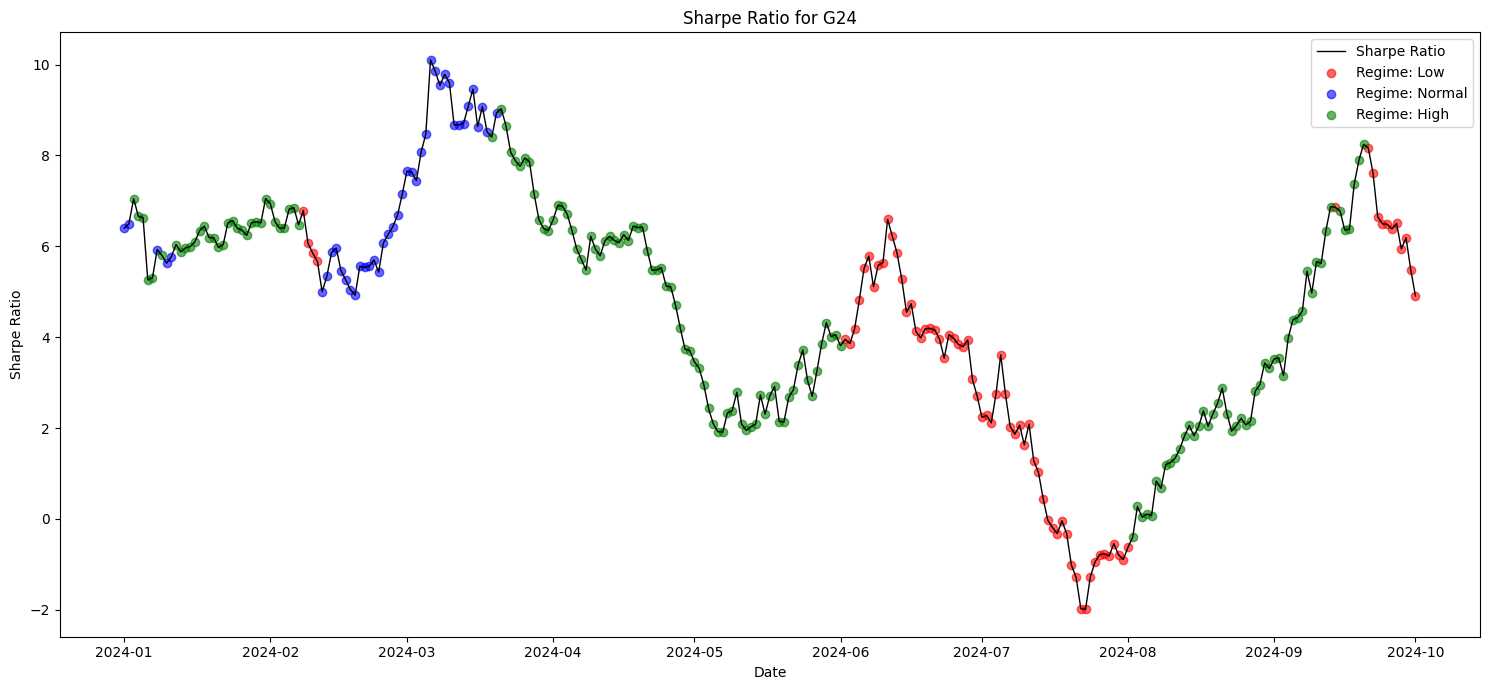

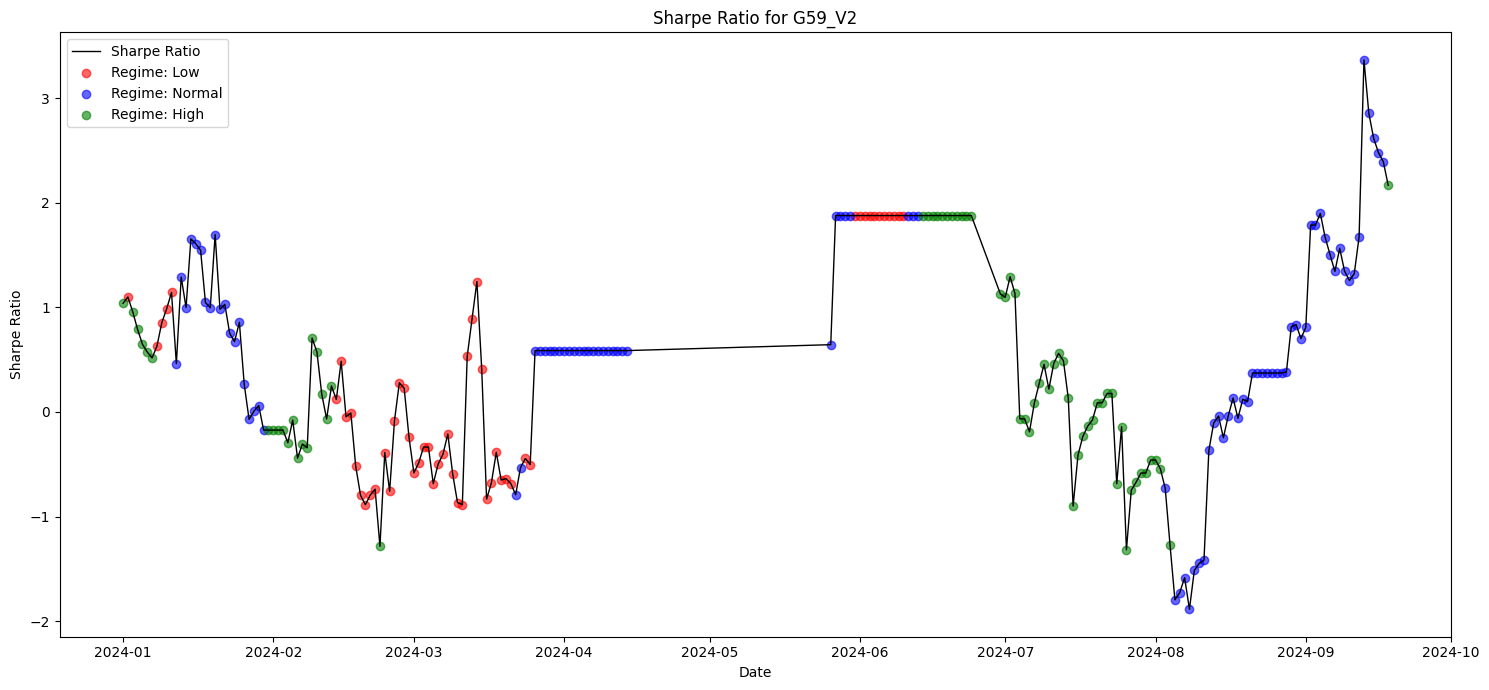

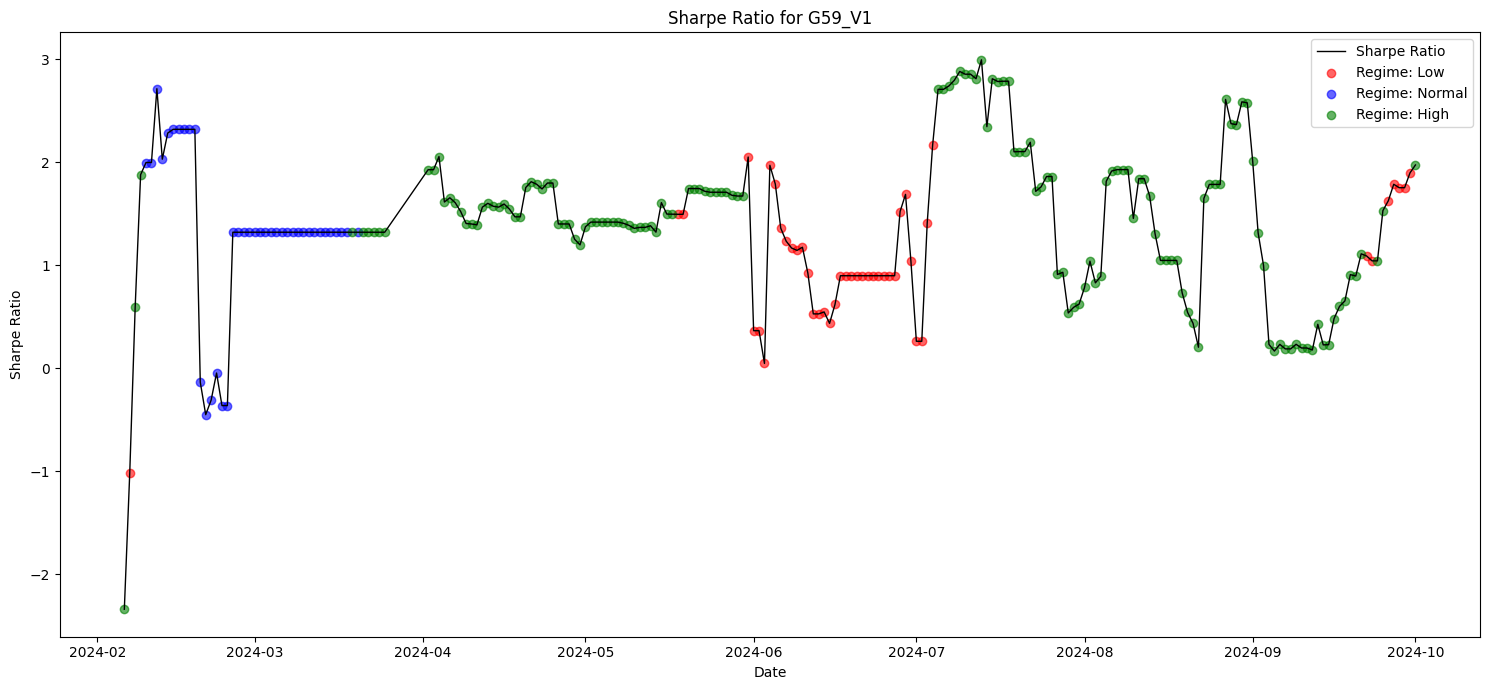

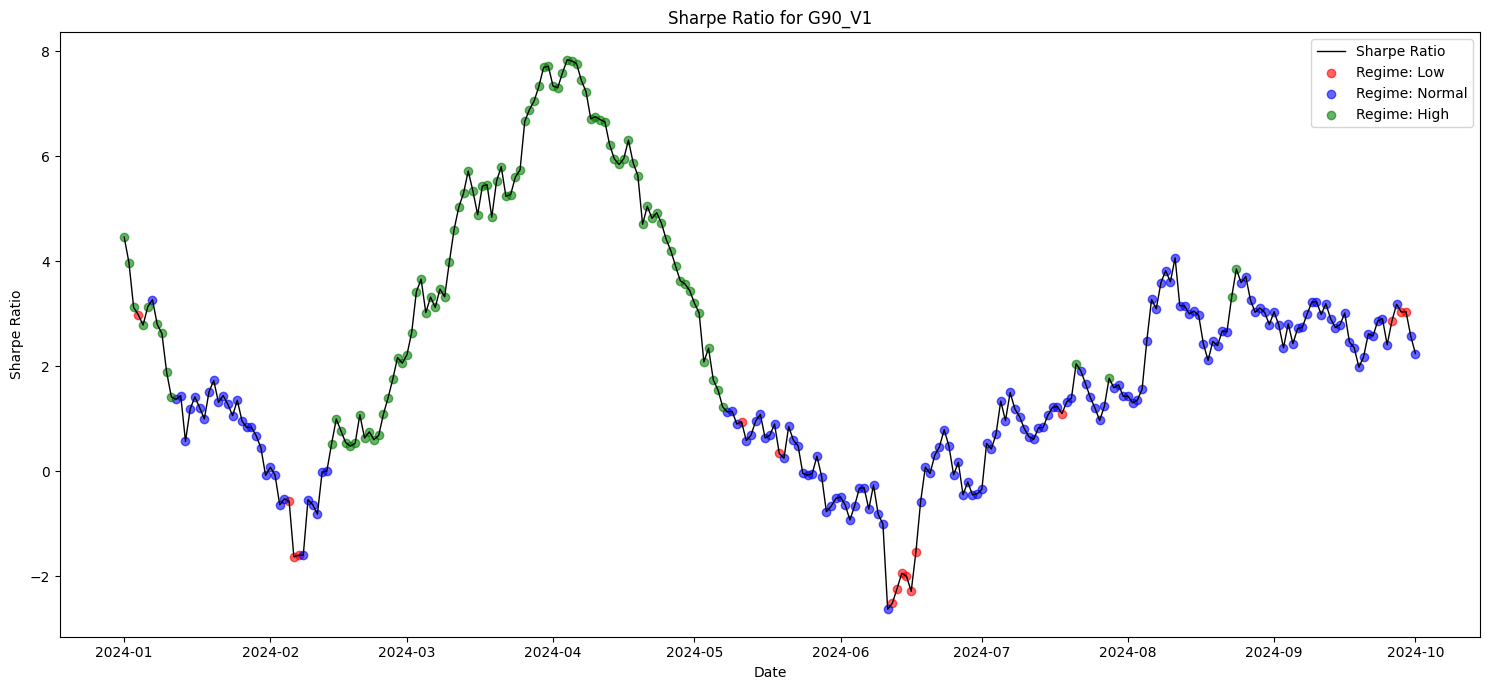

In [47]:
for strategy, df in test_data.items():
    plt.figure(figsize=(15,7))
    plt.plot(df.index, df['Sharpe_Ratio_60'], label='Sharpe Ratio', color='black', linewidth=1)
    
    colors = {'Low': 'red', 'Normal': 'blue', 'High': 'green'}
    
    for regime, color in colors.items():
        regime_data = df[df['Regime_Label'] == regime]
        plt.scatter(regime_data.index, regime_data['Sharpe_Ratio_60'], 
                    color=color, label=f'Regime: {regime}', alpha=0.6)
    
    plt.title(f'Sharpe Ratio for {strategy}')
    plt.xlabel('Date')
    plt.ylabel('Sharpe Ratio')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [50]:
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering, SpectralClustering

train_data, test_data = split_train_test(merged_data)

def fit_gmm(train_data, test_data, n_components=3, covariance_type='full'):
    gmm_models = {}
    train_labels = {}
    test_labels = {}
    
    for strategy in train_data.keys():
        X_train = train_data[strategy].drop(columns=['Sharpe_Ratio_60']).values
        X_test = test_data[strategy].drop(columns=['Sharpe_Ratio_60']).values
        
        gmm = GaussianMixture(n_components=n_components, covariance_type=covariance_type)
        
        gmm.fit(X_train)
        
        train_labels[strategy] = gmm.predict(X_train)
        
        test_labels[strategy] = gmm.predict(X_test)
        
        gmm_models[strategy] = gmm
        
    return gmm_models, train_labels, test_labels

gmm_models, gmm_train_labels, gmm_test_labels = fit_gmm(train_data, test_data, n_components=3, covariance_type='full')


In [52]:
def map_gmm_clusters_to_regimes(train_data, train_labels, test_labels, regime_labels=['Low', 'Normal', 'High']):
    train_regime_labels = {}
    test_regime_labels = {}
    
    for strategy in train_data.keys():
        df_train = train_data[strategy].copy()
        labels = train_labels[strategy]
        df_train['Cluster'] = labels
        
        cluster_sharpe = df_train.groupby('Cluster')['Sharpe_Ratio_60'].mean()
        
        sorted_clusters = cluster_sharpe.sort_values().index.tolist()
        regime_mapping = {}
        if len(sorted_clusters) >= len(regime_labels):
            regime_mapping = {cluster: label for cluster, label in zip(sorted_clusters[:len(regime_labels)], regime_labels)}
            for cluster in sorted_clusters[len(regime_labels):]:
                regime_mapping[cluster] = f'Label_{cluster}'
        else:
            regime_mapping = {cluster: label for cluster, label in zip(sorted_clusters, regime_labels[:len(sorted_clusters)])}
        
        df_train['Regime_Label'] = df_train['Cluster'].map(regime_mapping)
        train_regime_labels[strategy] = df_train['Regime_Label']
        
        labels_test = test_labels[strategy]
        df_test = test_data[strategy]
        
        regime_label_test = []
        for lbl in labels_test:
            regime = regime_mapping.get(lbl, 'Noise')  # 'Noise' if label not found
            regime_label_test.append(regime)
        
        test_regime_labels[strategy] = regime_label_test
        
    return train_regime_labels, test_regime_labels

gmm_train_regime_labels, gmm_test_regime_labels = map_gmm_clusters_to_regimes(
    train_data, 
    gmm_train_labels, 
    gmm_test_labels, 
    regime_labels=['Low', 'Normal', 'High']
)

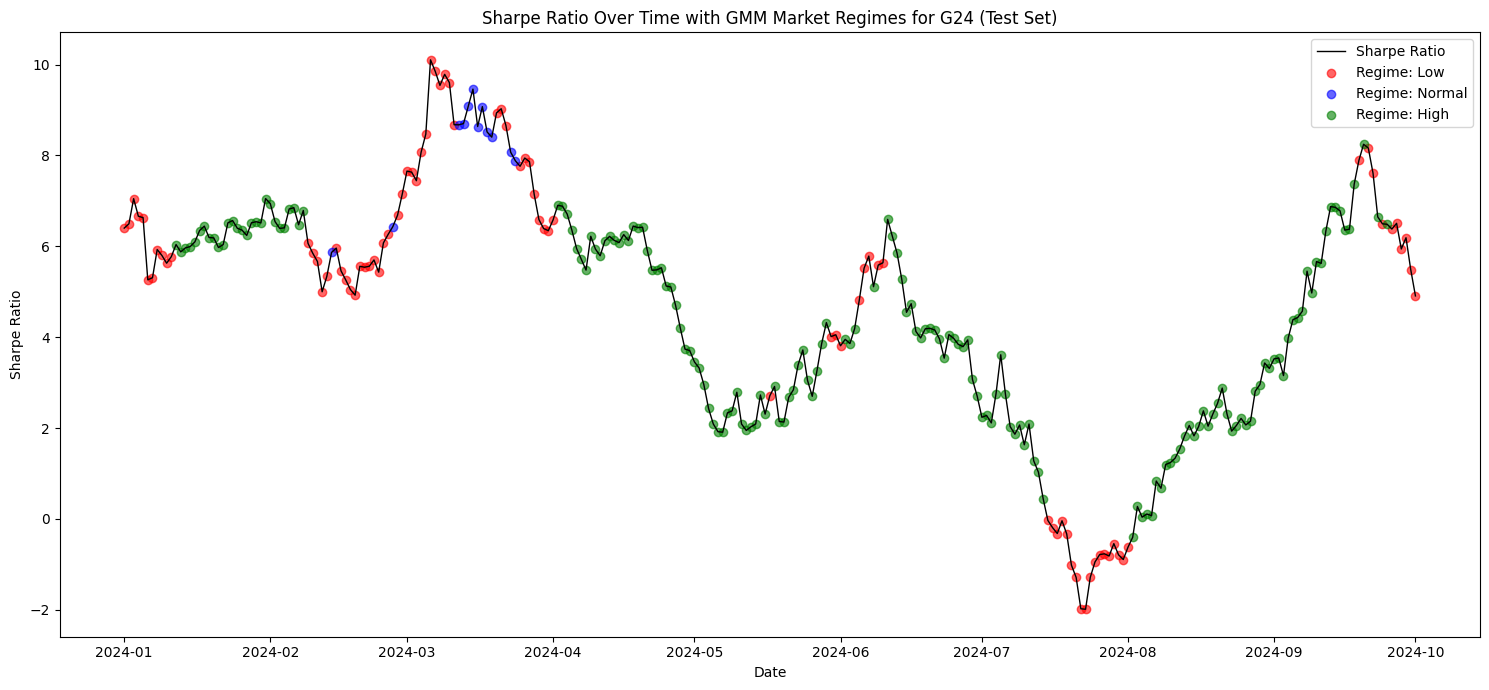

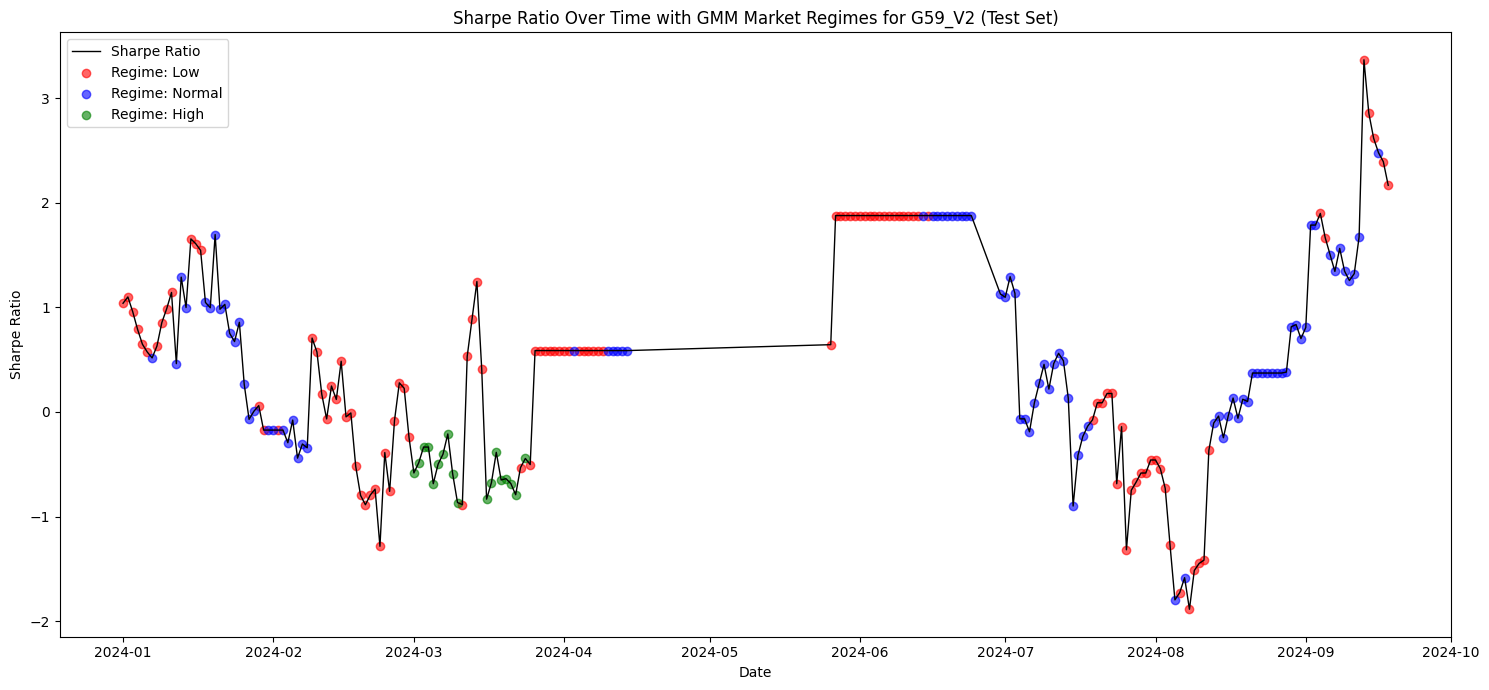

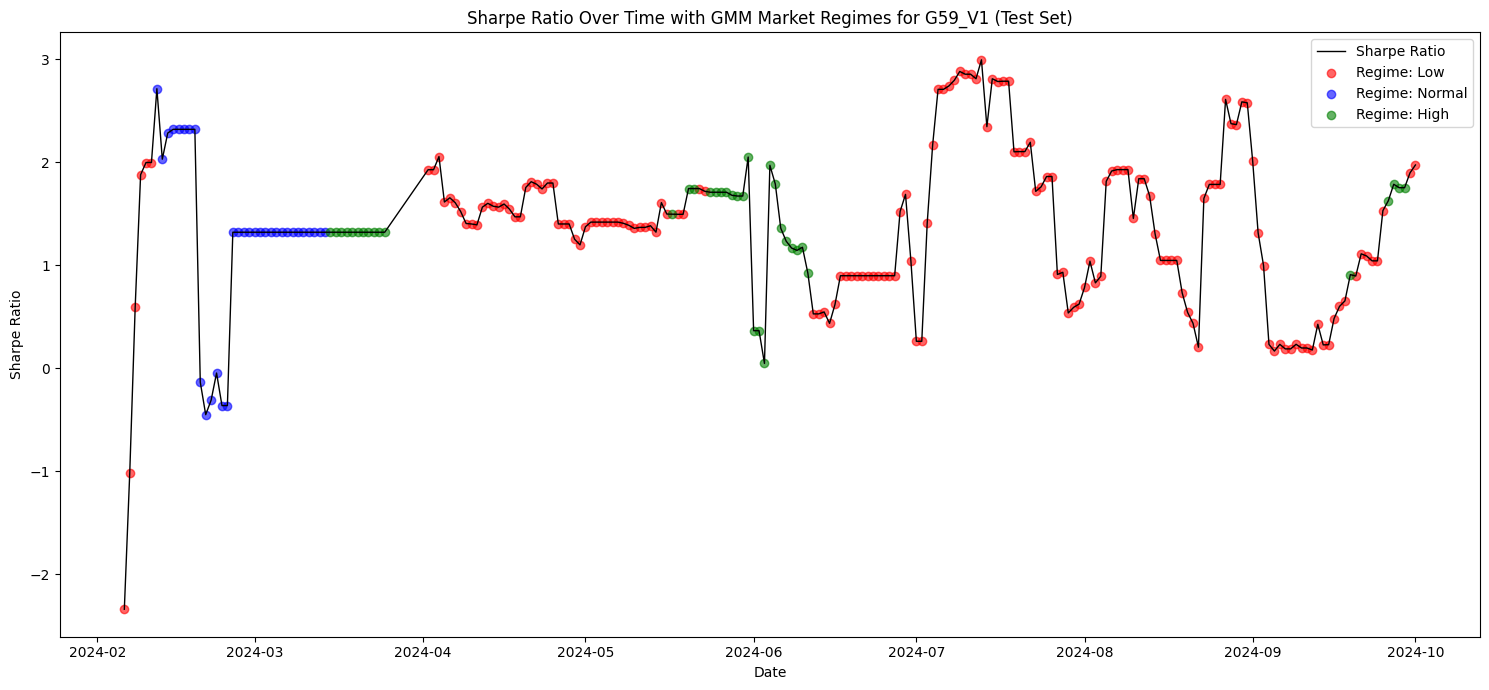

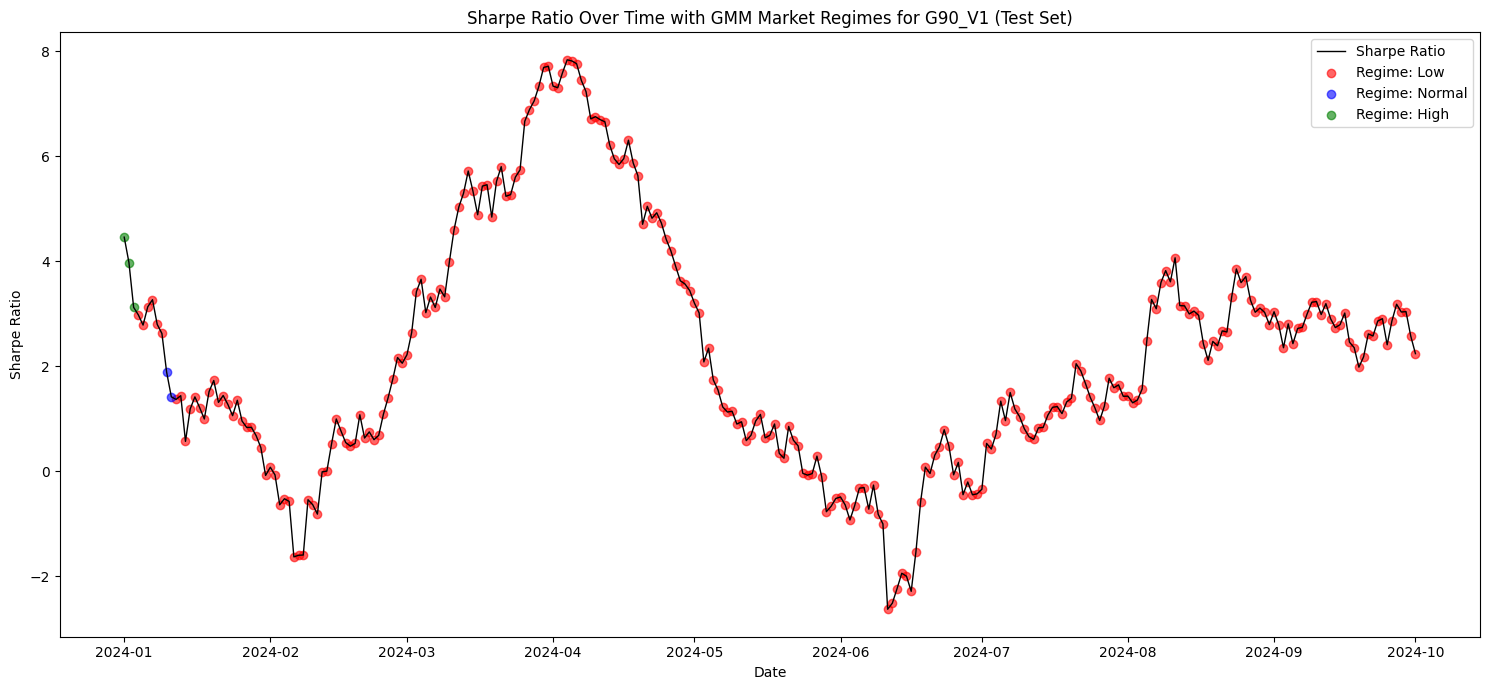

In [55]:
def visualize_gmm_regimes(test_data, test_regime_labels, strategy):
    df_test = test_data[strategy].copy()
    df_test['Regime_Label'] = test_regime_labels[strategy]
    df_test['datetime'] = df_test.index  
    
    plt.figure(figsize=(15,7))
    
    plt.plot(df_test['datetime'], df_test['Sharpe_Ratio_60'], label='Sharpe Ratio', color='black', linewidth=1)
    
    unique_regimes = df_test['Regime_Label'].unique()
    palette = sns.color_palette("Set1", len(unique_regimes))
    colors = get_regime_colors(df_test['Regime_Label'])    
    
    for regime, color in REGIME_COLOR_MAPPING.items():
        regime_data = df_test[df_test['Regime_Label'] == regime]
        if regime == 'Noise':
            plt.scatter(regime_data['datetime'], regime_data['Sharpe_Ratio_60'], 
                        color=color, label=f'Regime: {regime}', alpha=0.6, marker='x')
        else:
            plt.scatter(regime_data['datetime'], regime_data['Sharpe_Ratio_60'], 
                        color=color, label=f'Regime: {regime}', alpha=0.6, marker='o')
    
    plt.title(f'Sharpe Ratio Over Time with GMM Market Regimes for {strategy} (Test Set)')
    plt.xlabel('Date')
    plt.ylabel('Sharpe Ratio')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"clustering_models/GMM/{strategy}.png")
    plt.show()

for strategy in test_data.keys():
    visualize_gmm_regimes(test_data, gmm_test_regime_labels, strategy)

In [57]:
train_data, test_data = split_train_test(merged_data)

def fit_agglomerative(train_data, test_data, n_clusters=3, linkage='ward'):
    agg_models = {}
    train_labels = {}
    test_labels = {}
    
    for strategy in train_data.keys():
        X_train = train_data[strategy].drop(columns=['Sharpe_Ratio_60']).values
        X_test = test_data[strategy].drop(columns=['Sharpe_Ratio_60']).values
        
        agg = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage)
        
        agg.fit(X_train)
        
        train_labels[strategy] = agg.labels_
        centroids = {}
        for cluster in range(n_clusters):
            centroids[cluster] = X_train[agg.labels_ == cluster].mean(axis=0)
        
        centroids_array = np.array(list(centroids.values()))
        
        neighbors = NearestNeighbors(n_neighbors=1)
        neighbors.fit(centroids_array)
        
        distances, indices = neighbors.kneighbors(X_test)
        assigned_labels = indices.flatten()
        
        test_labels[strategy] = assigned_labels
        
        agg_models[strategy] = agg
        
    return agg_models, train_labels, test_labels

agg_models, agg_train_labels, agg_test_labels = fit_agglomerative(
    train_data, 
    test_data, 
    n_clusters=3, 
    linkage='ward'  
)

In [58]:
def map_agg_clusters_to_regimes(train_data, train_labels, test_labels, regime_labels=['Low', 'Normal', 'High']):
    train_regime_labels = {}
    test_regime_labels = {}
    
    for strategy in train_data.keys():
        df_train = train_data[strategy].copy()
        labels = train_labels[strategy]
        df_train['Cluster'] = labels
        
        cluster_sharpe = df_train.groupby('Cluster')['Sharpe_Ratio_60'].mean()
        
        sorted_clusters = cluster_sharpe.sort_values().index.tolist()
        
        regime_mapping = {}
        if len(sorted_clusters) >= len(regime_labels):
            regime_mapping = {cluster: label for cluster, label in zip(sorted_clusters[:len(regime_labels)], regime_labels)}
            for cluster in sorted_clusters[len(regime_labels):]:
                regime_mapping[cluster] = f'Label_{cluster}'
        else:
            regime_mapping = {cluster: label for cluster, label in zip(sorted_clusters, regime_labels[:len(sorted_clusters)])}
        
        df_train['Regime_Label'] = df_train['Cluster'].map(regime_mapping)
        train_regime_labels[strategy] = df_train['Regime_Label']
        
        labels_test = test_labels[strategy]
        df_test = test_data[strategy]
        
        regime_label_test = []
        for lbl in labels_test:
            regime = regime_mapping.get(lbl, 'Noise')  #  'Noise' if label not found
            regime_label_test.append(regime)
        
        test_regime_labels[strategy] = regime_label_test
        
    return train_regime_labels, test_regime_labels

agg_train_regime_labels, agg_test_regime_labels = map_agg_clusters_to_regimes(
    train_data, 
    agg_train_labels, 
    agg_test_labels, 
    regime_labels=['Low', 'Normal', 'High']
)


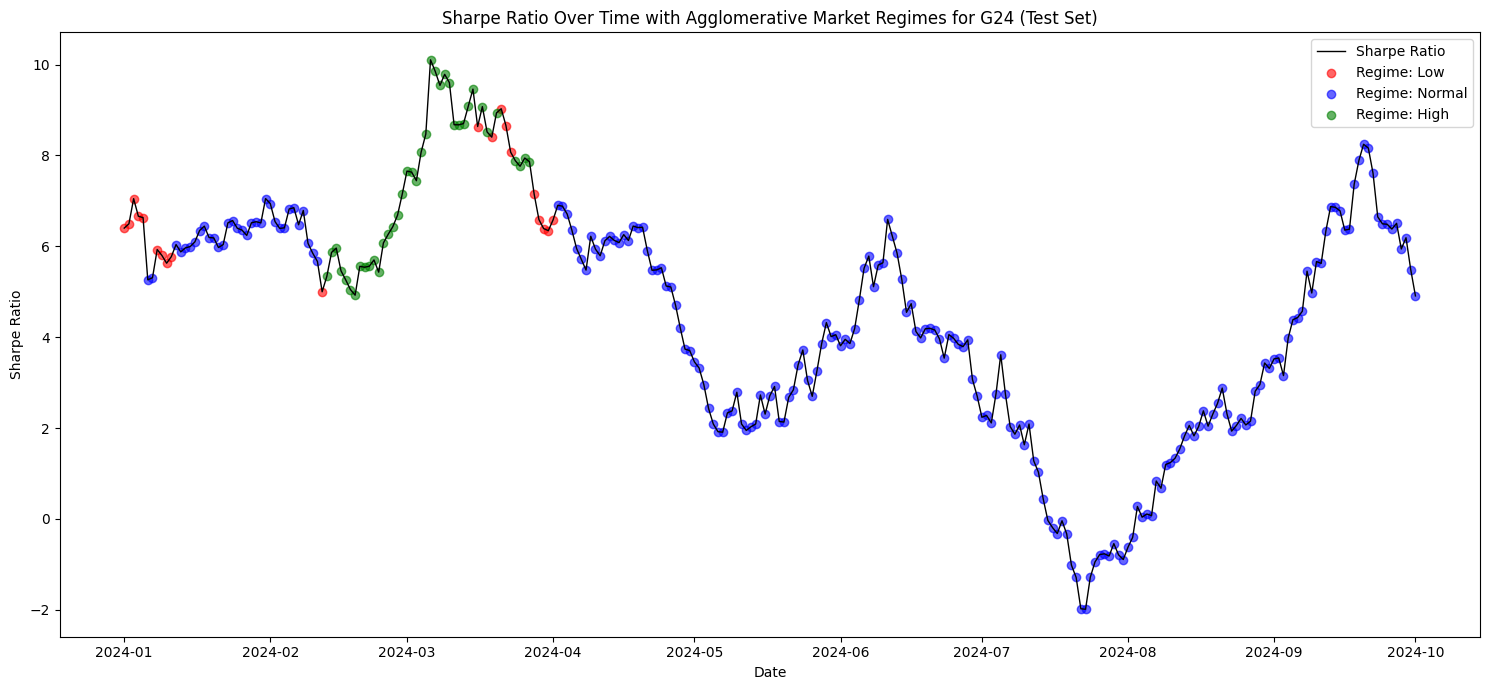

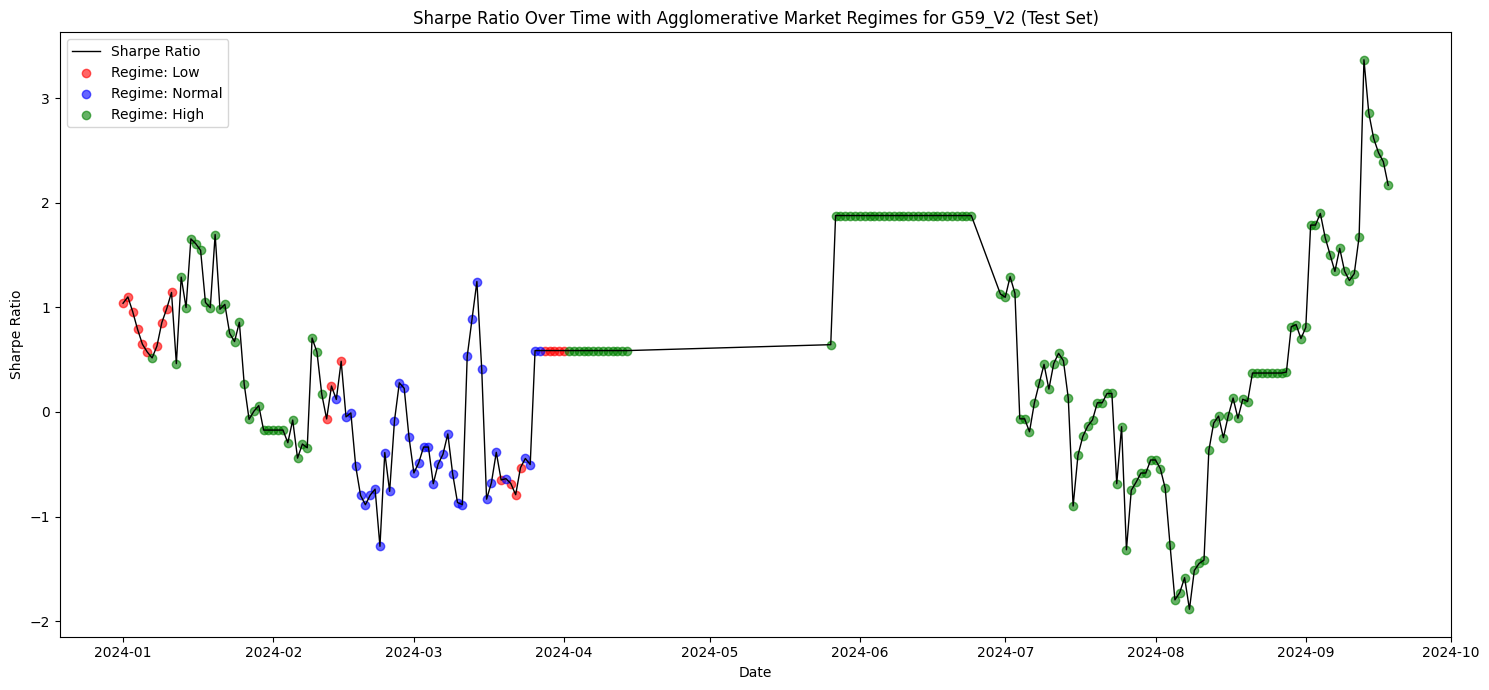

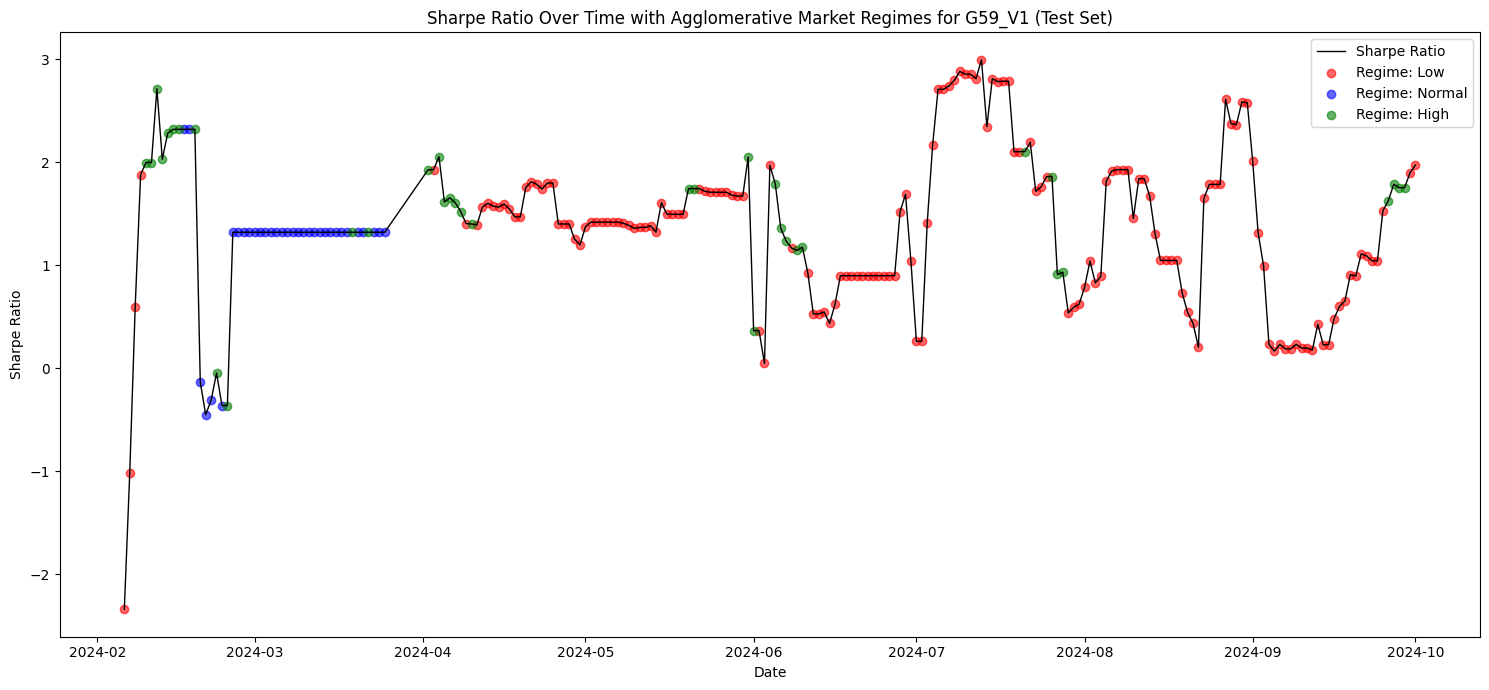

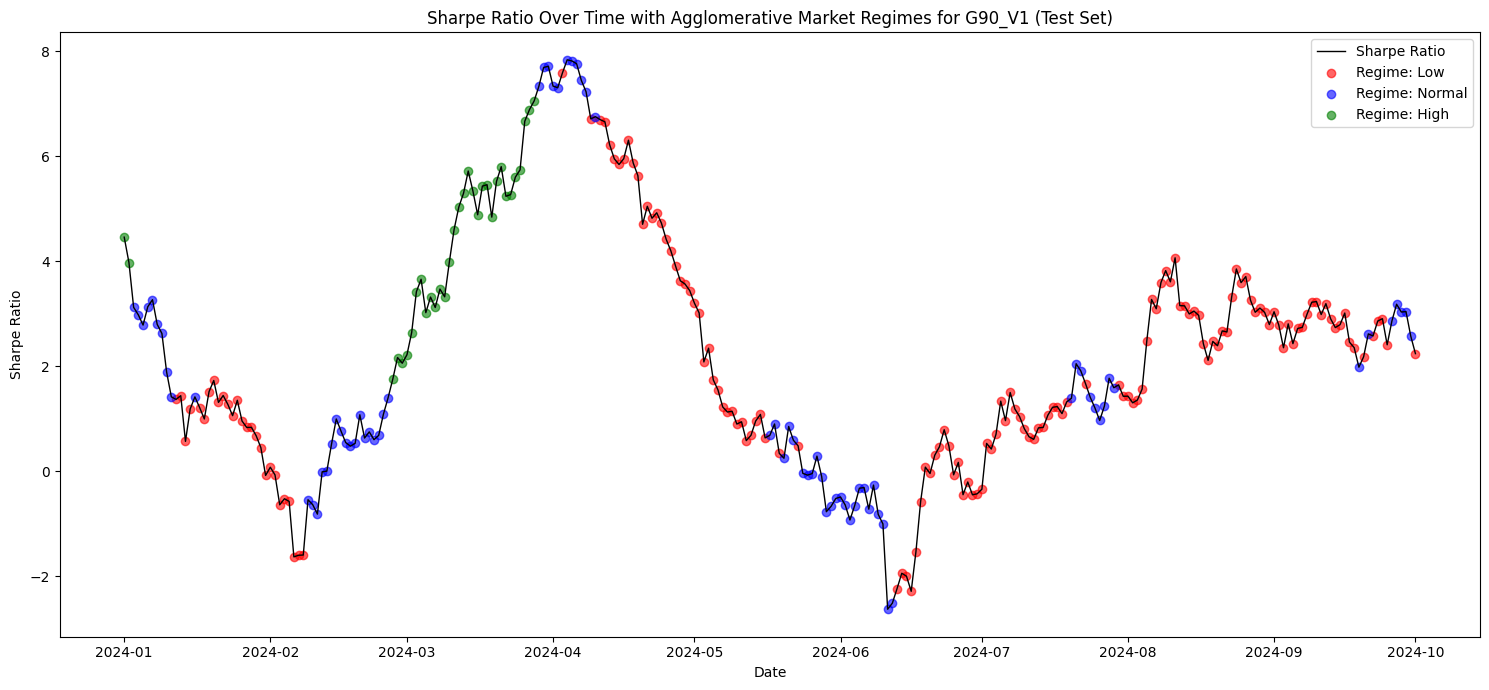

In [59]:
def visualize_agg_regimes(test_data, test_regime_labels, strategy):
    df_test = test_data[strategy].copy()
    df_test['Regime_Label'] = test_regime_labels[strategy]
    df_test['datetime'] = df_test.index 
    
    plt.figure(figsize=(15,7))
    
    plt.plot(df_test['datetime'], df_test['Sharpe_Ratio_60'], label='Sharpe Ratio', color='black', linewidth=1)
    
    unique_regimes = df_test['Regime_Label'].unique()
    palette = sns.color_palette("Set1", len(unique_regimes))
    colors = get_regime_colors(df_test['Regime_Label'])    
    
    for regime, color in REGIME_COLOR_MAPPING.items():
        regime_data = df_test[df_test['Regime_Label'] == regime]
        if regime == 'Noise':
            plt.scatter(regime_data['datetime'], regime_data['Sharpe_Ratio_60'], 
                        color=color, label=f'Regime: {regime}', alpha=0.6, marker='x')
        else:
            plt.scatter(regime_data['datetime'], regime_data['Sharpe_Ratio_60'], 
                        color=color, label=f'Regime: {regime}', alpha=0.6, marker='o')
    
    plt.title(f'Sharpe Ratio Over Time with Agglomerative Market Regimes for {strategy} (Test Set)')
    plt.xlabel('Date')
    plt.ylabel('Sharpe Ratio')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"clustering_models/AHC/{strategy}.png")
    plt.show()

for strategy in test_data.keys():
    visualize_agg_regimes(test_data, agg_test_regime_labels, strategy)

In [60]:
from sklearn.cluster import Birch, MiniBatchKMeans
from sklearn.neighbors import NearestCentroid

def fit_birch(train_data, test_data, n_clusters=3, threshold=0.5, branching_factor=50):
    birch_models = {}
    train_labels = {}
    test_labels = {}
    
    for strategy in train_data.keys():
        X_train = train_data[strategy].drop(columns=['Sharpe_Ratio_60']).values
        X_test = test_data[strategy].drop(columns=['Sharpe_Ratio_60']).values
        
        birch = Birch(n_clusters=None, threshold=threshold, branching_factor=branching_factor)
        
        birch.fit(X_train)
        
        kmeans = MiniBatchKMeans(n_clusters=n_clusters)
        kmeans.fit(birch.predict(X_train).reshape(-1,1))
        
        train_labels[strategy] = kmeans.predict(birch.predict(X_train).reshape(-1,1))
        
        centroid_classifier = NearestCentroid()
        centroid_classifier.fit(kmeans.cluster_centers_, range(n_clusters))
        test_labels[strategy] = centroid_classifier.predict(birch.predict(X_test).reshape(-1,1))
        
        birch_models[strategy] = (birch, kmeans)
        
    return birch_models, train_labels, test_labels

birch_models, birch_train_labels, birch_test_labels = fit_birch(
    train_data, 
    test_data, 
    n_clusters=3, 
    threshold=0.5, 
    branching_factor=50
)


In [61]:
def map_birch_clusters_to_regimes(train_data, train_labels, test_labels, regime_labels=['Low', 'Normal', 'High']):
    train_regime_labels = {}
    test_regime_labels = {}
    
    for strategy in train_data.keys():
        df_train = train_data[strategy].copy()
        labels = train_labels[strategy]
        df_train['Cluster'] = labels
        
        cluster_sharpe = df_train.groupby('Cluster')['Sharpe_Ratio_60'].mean()
        
        sorted_clusters = cluster_sharpe.sort_values().index.tolist()
        
        regime_mapping = {}
        if len(sorted_clusters) >= len(regime_labels):
            regime_mapping = {cluster: label for cluster, label in zip(sorted_clusters[:len(regime_labels)], regime_labels)}
            for cluster in sorted_clusters[len(regime_labels):]:
                regime_mapping[cluster] = f'Label_{cluster}'
        else:
            regime_mapping = {cluster: label for cluster, label in zip(sorted_clusters, regime_labels[:len(sorted_clusters)])}
        
        df_train['Regime_Label'] = df_train['Cluster'].map(regime_mapping)
        train_regime_labels[strategy] = df_train['Regime_Label']
        
        labels_test = test_labels[strategy]
        df_test = test_data[strategy]
        
        regime_label_test = []
        for lbl in labels_test:
            regime = regime_mapping.get(lbl, 'Noise')  
            regime_label_test.append(regime)
        
        test_regime_labels[strategy] = regime_label_test
        
    return train_regime_labels, test_regime_labels

birch_train_regime_labels, birch_test_regime_labels = map_birch_clusters_to_regimes(
    train_data, 
    birch_train_labels, 
    birch_test_labels, 
    regime_labels=['Low', 'Normal', 'High']
)


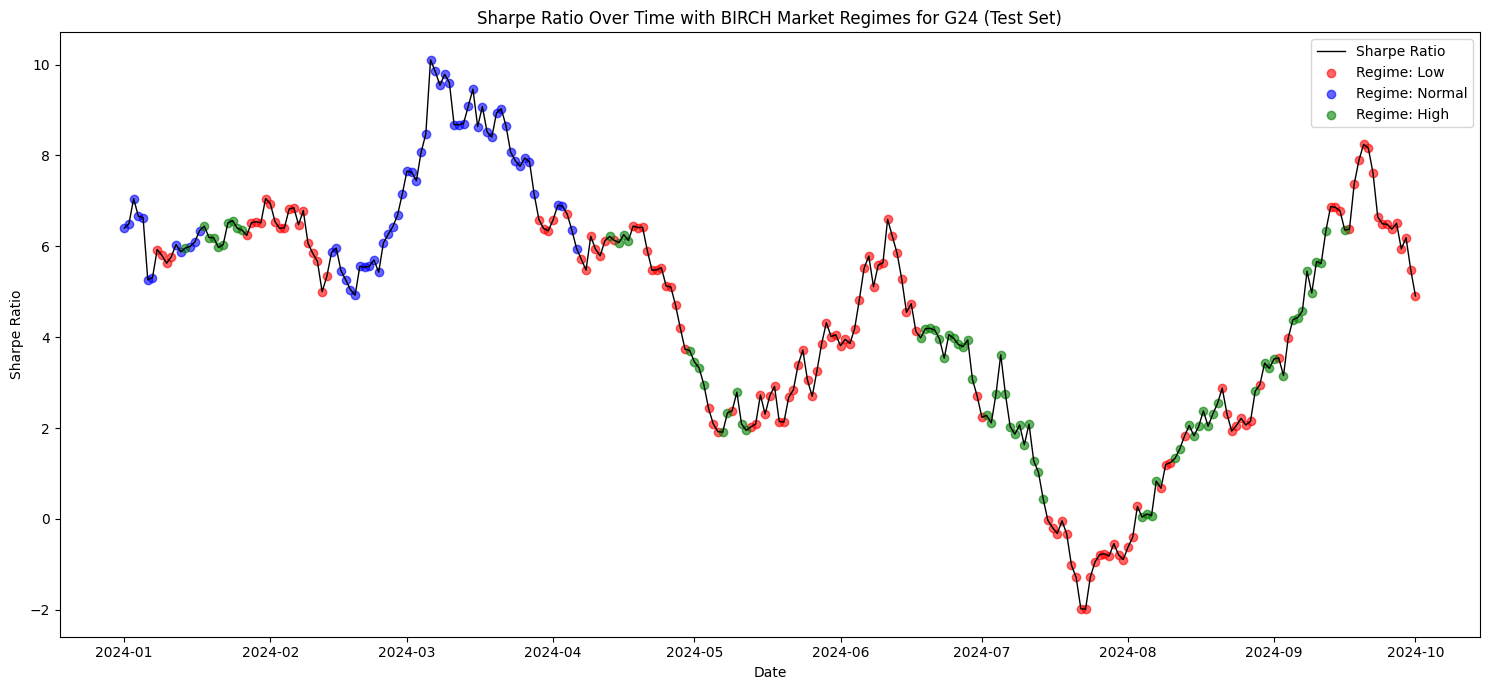

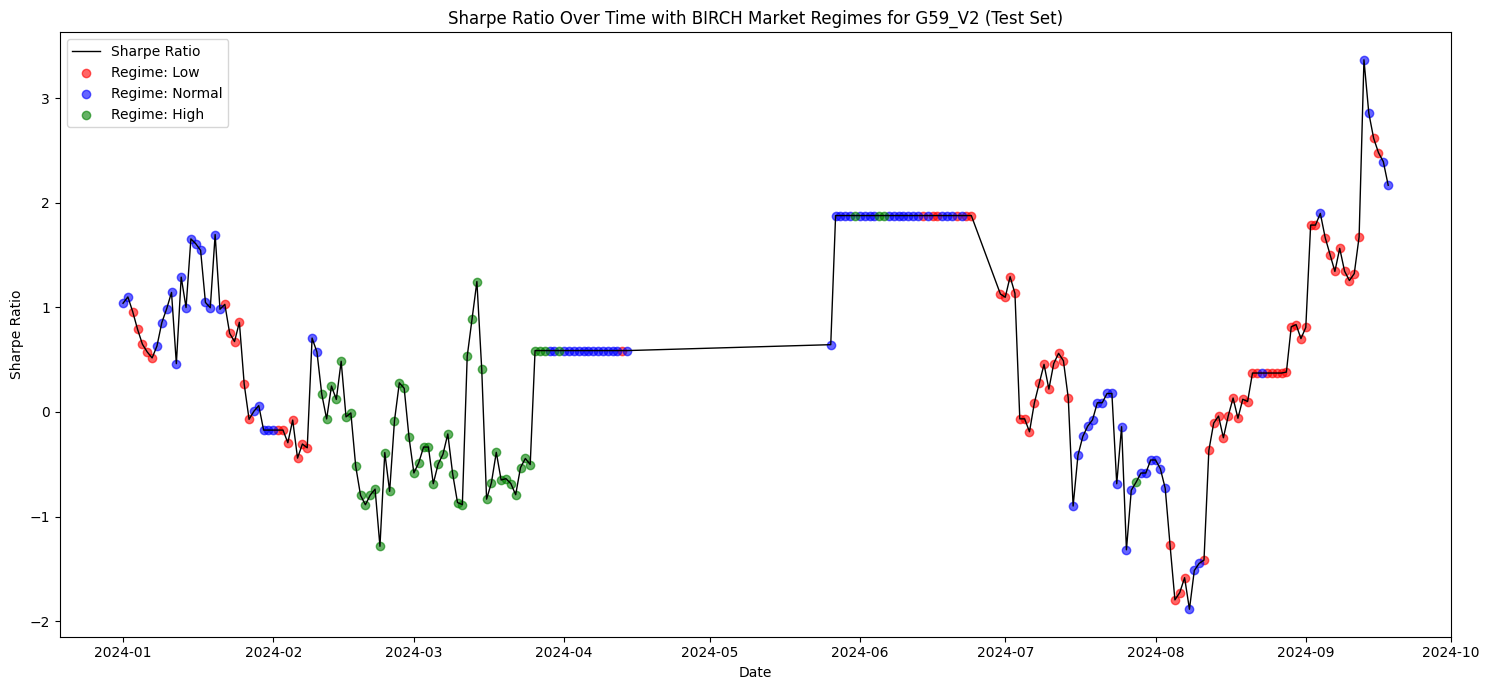

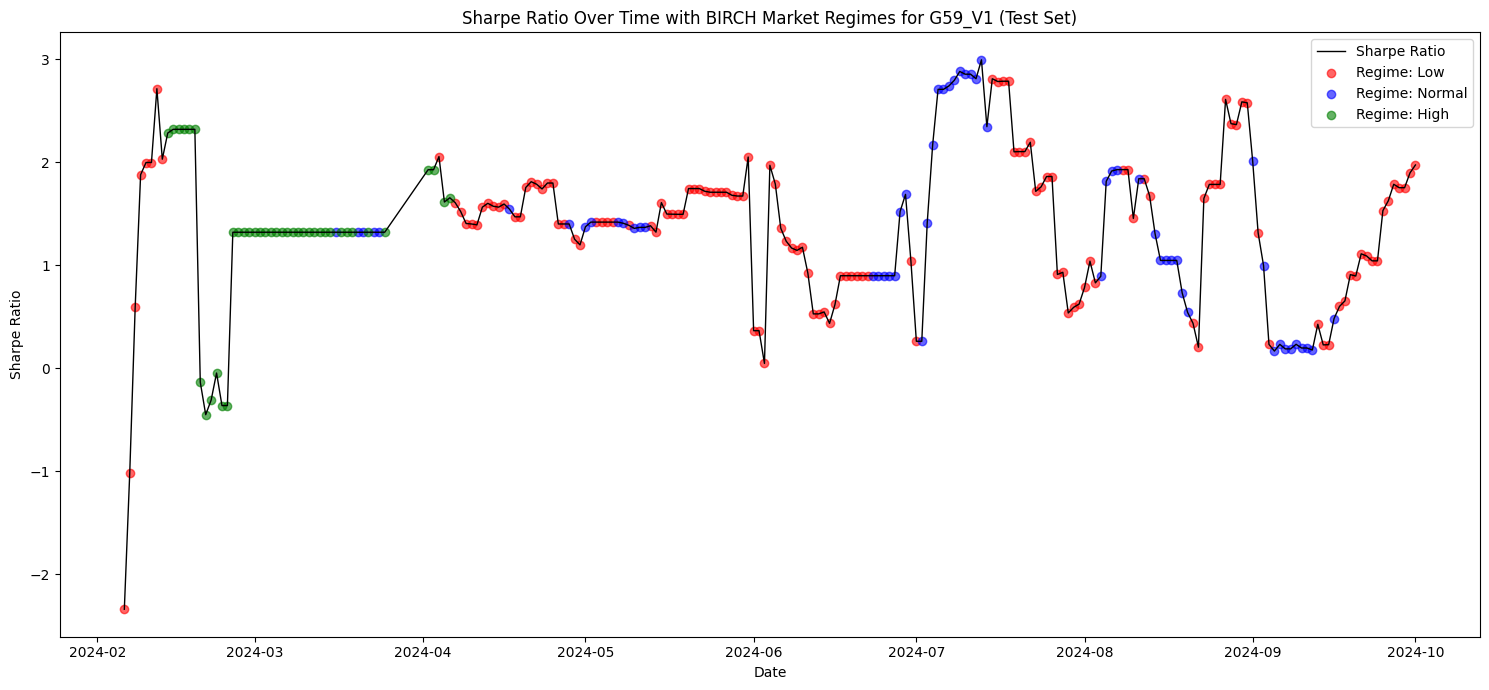

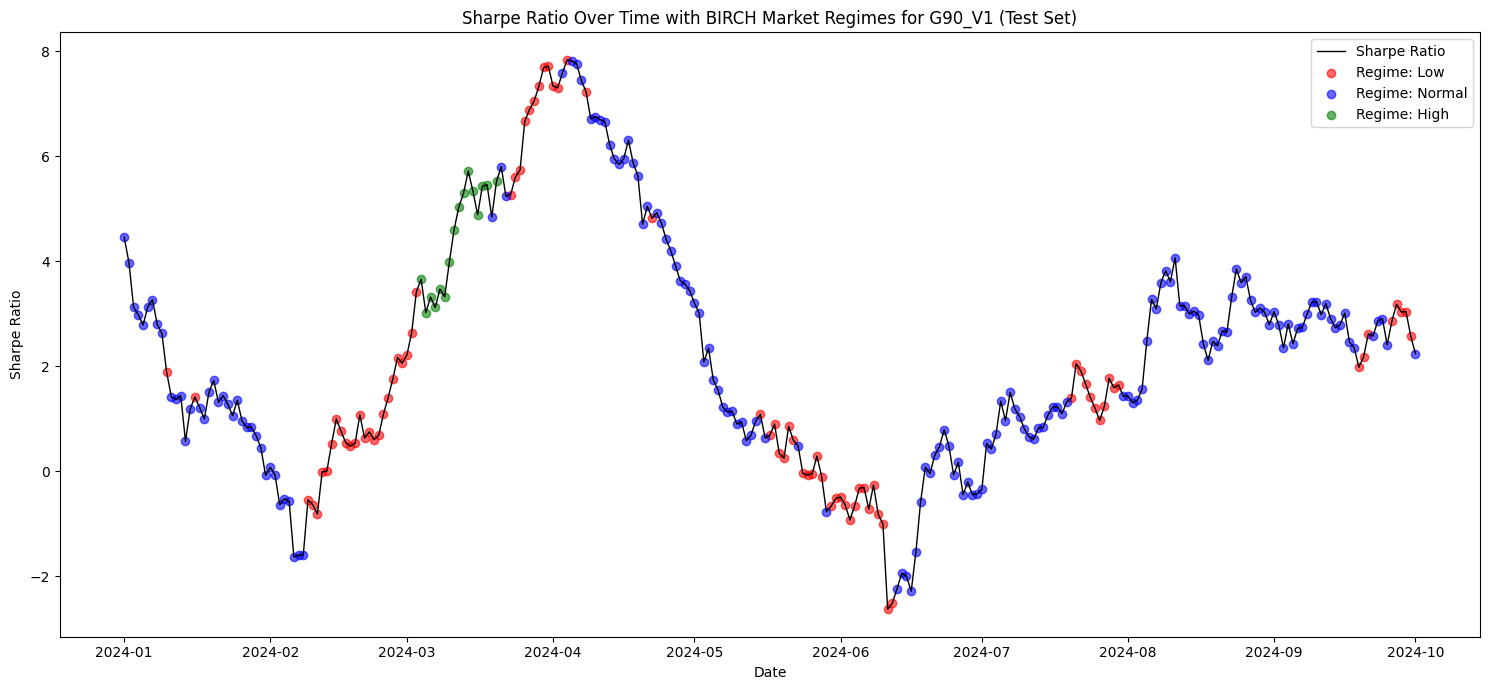

In [62]:
def visualize_birch_regimes(test_data, test_regime_labels, strategy):
    df_test = test_data[strategy].copy()
    df_test['Regime_Label'] = test_regime_labels[strategy]
    df_test['datetime'] = df_test.index 
    
    plt.figure(figsize=(15,7))
    
    plt.plot(df_test['datetime'], df_test['Sharpe_Ratio_60'], label='Sharpe Ratio', color='black', linewidth=1)
    
    unique_regimes = df_test['Regime_Label'].unique()
    palette = sns.color_palette("Set1", len(unique_regimes))
    colors = get_regime_colors(df_test['Regime_Label'])    
    
    for regime, color in REGIME_COLOR_MAPPING.items():
        regime_data = df_test[df_test['Regime_Label'] == regime]
        if regime == 'Noise':
            plt.scatter(regime_data['datetime'], regime_data['Sharpe_Ratio_60'], 
                        color=color, label=f'Regime: {regime}', alpha=0.6, marker='x')
        else:
            plt.scatter(regime_data['datetime'], regime_data['Sharpe_Ratio_60'], 
                        color=color, label=f'Regime: {regime}', alpha=0.6, marker='o')
    
    plt.title(f'Sharpe Ratio Over Time with BIRCH Market Regimes for {strategy} (Test Set)')
    plt.xlabel('Date')
    plt.ylabel('Sharpe Ratio')
    plt.legend()
    plt.tight_layout()
    plt.show()

for strategy in test_data.keys():
    visualize_birch_regimes(test_data, birch_test_regime_labels, strategy)


In [70]:
from sklearn_extra.cluster import KMedoids
from dtaidistance import dtw
from scipy.stats import wasserstein_distance

def dtw_distance(x, y):
    return dtw(x, y)

def pad_truncate_sequences(sequences, max_length):
    fixed_length_sequences = []
    for seq in sequences:
        if len(seq) < max_length:
            # Pad with zeros
            padded_seq = np.pad(seq, (0, max_length - len(seq)), 'constant')
        else:
            # Truncate to max_length
            padded_seq = seq[:max_length]
        fixed_length_sequences.append(padded_seq)
    return np.array(fixed_length_sequences)

def scale_sequences(sequences):
    scaler = StandardScaler()
    n_samples, n_timesteps = sequences.shape
    scaler.fit(sequences)
    scaled_sequences = scaler.transform(sequences)
    return scaled_sequences


def fit_vlstar(train_data, test_data, n_clusters=3):
    kmedoids_models = {}
    train_labels = {}
    test_labels = {}
    
    for strategy in train_data.keys():
        X_train = train_data[strategy]['Sharpe_Ratio_60'].values.tolist()
        X_test = test_data[strategy]['Sharpe_Ratio_60'].values.tolist()
        
        X_train = np.array(X_train)
        X_test = np.array(X_test)
        
        # Handle variable-length sequences by padding/truncating
        max_length_train = X_train.shape[1] if X_train.ndim > 1 else 1
        max_length_test = X_test.shape[1] if X_test.ndim > 1 else 1
        max_length = max(max_length_train, max_length_test)
        
        if X_train.ndim == 1:
            X_train = X_train.reshape(-1, 1)
        if X_test.ndim == 1:
            X_test = X_test.reshape(-1, 1)
        
        X_train_padded = pad_truncate_sequences(X_train, max_length)
        X_test_padded = pad_truncate_sequences(X_test, max_length)
        
        X_train_scaled = scale_sequences(X_train_padded)
        X_test_scaled = scale_sequences(X_test_padded)
        
        #distance matrix for training data
        distance_matrix = np.zeros((X_train_scaled.shape[0], X_train_scaled.shape[0]))
        for i in range(X_train_scaled.shape[0]):
            for j in range(i + 1, X_train_scaled.shape[0]):
                distance = dtw.distance(X_train_scaled[i], X_train_scaled[j])
                distance_matrix[i, j] = distance
                distance_matrix[j, i] = distance  # Symmetric matrix
        
        kmedoids = KMedoids(n_clusters=n_clusters, metric='precomputed', init='k-medoids++', random_state=42)
        
        kmedoids.fit(distance_matrix)
        
        train_labels[strategy] = kmedoids.labels_
        
        medoid_indices = kmedoids.medoid_indices_
        medoids = X_train_scaled[medoid_indices]
        
        distances_test = np.zeros((X_test_scaled.shape[0], n_clusters))
        for i in range(X_test_scaled.shape[0]):
            for j in range(n_clusters):
                distances_test[i, j] = dtw.distance(X_test_scaled[i], medoids[j])
        
        test_labels[strategy] = distances_test.argmin(axis=1)
        
        kmedoids_models[strategy] = kmedoids
        
    return kmedoids_models, train_labels, test_labels

def visualize_regimes(test_data, test_regime_labels, strategy, method_name='Clustering'):
    df_test = test_data[strategy].copy()
    df_test['Regime_Label'] = test_regime_labels[strategy]
    df_test['datetime'] = df_test.index  
    
    plt.figure(figsize=(15,7))
    
    plt.plot(df_test['datetime'], df_test['Sharpe_Ratio_60'], label='Sharpe Ratio', color='black', linewidth=1)
    
    colors = get_regime_colors(df_test['Regime_Label'])
    
    plt.scatter(df_test['datetime'], df_test['Sharpe_Ratio_60'], 
                c=colors, label=df_test['Regime_Label'], alpha=0.6, marker='o')
    
    handles = []
    labels = []
    for regime, color in REGIME_COLOR_MAPPING.items():
        handles.append(plt.Line2D([0], [0], marker='o', color='w', label=regime,
                                  markerfacecolor=color, markersize=10))
        labels.append(regime)
    if 'Noise' in df_test['Regime_Label'].unique():
        handles.append(plt.Line2D([0], [0], marker='x', color='w', label='Noise',
                                  markerfacecolor='gray', markersize=10))
        labels.append('Noise')
    
    plt.legend(handles, labels)
    plt.title(f'Sharpe Ratio Over Time with {method_name} Market Regimes for {strategy} (Test Set)')
    plt.xlabel('Date')
    plt.ylabel('Sharpe Ratio')
    plt.tight_layout()
    plt.show()

In [67]:
def map_clusters_to_regimes(train_data, train_labels, test_labels, regime_labels=['Low', 'Normal', 'High']):
    train_regime_labels = {}
    test_regime_labels = {}
    
    for strategy in train_data.keys():
        df_train = train_data[strategy].copy()
        labels = train_labels[strategy]
        df_train['Cluster'] = labels
        
        cluster_sharpe = df_train.groupby('Cluster')['Sharpe_Ratio_60'].mean()
        
        sorted_clusters = cluster_sharpe.sort_values().index.tolist()
        
        regime_mapping = {}
        num_regimes = len(regime_labels)
        if len(sorted_clusters) >= num_regimes:
            for cluster, label in zip(sorted_clusters[:num_regimes], regime_labels):
                regime_mapping[cluster] = label
            for cluster in sorted_clusters[num_regimes:]:
                regime_mapping[cluster] = f'Label_{cluster}'
        else:
            for cluster, label in zip(sorted_clusters, regime_labels):
                regime_mapping[cluster] = label
        
        df_train['Regime_Label'] = df_train['Cluster'].map(regime_mapping)
        train_regime_labels[strategy] = df_train['Regime_Label']
        
        labels_test = test_labels[strategy]
        regime_label_test = []
        for lbl in labels_test:
            regime = regime_mapping.get(lbl, 'Noise')  # Assign 'Noise' if label not found
            regime_label_test.append(regime)
        
        test_regime_labels[strategy] = regime_label_test
        
    return train_regime_labels, test_regime_labels


In [68]:
strategy_names = train_data.keys()  

print("fitting..")
kmedoids_models_vlstar, vlstar_train_labels, vlstar_test_labels = fit_vlstar(
    train_data, 
    test_data, 
    n_clusters=3
)

vlstar_train_regime_labels, vlstar_test_regime_labels = map_clusters_to_regimes(
    train_data, 
    vlstar_train_labels, 
    vlstar_test_labels, 
    regime_labels=['Low', 'Normal', 'High']
)

Fitting VLSTAR-like Clustering:


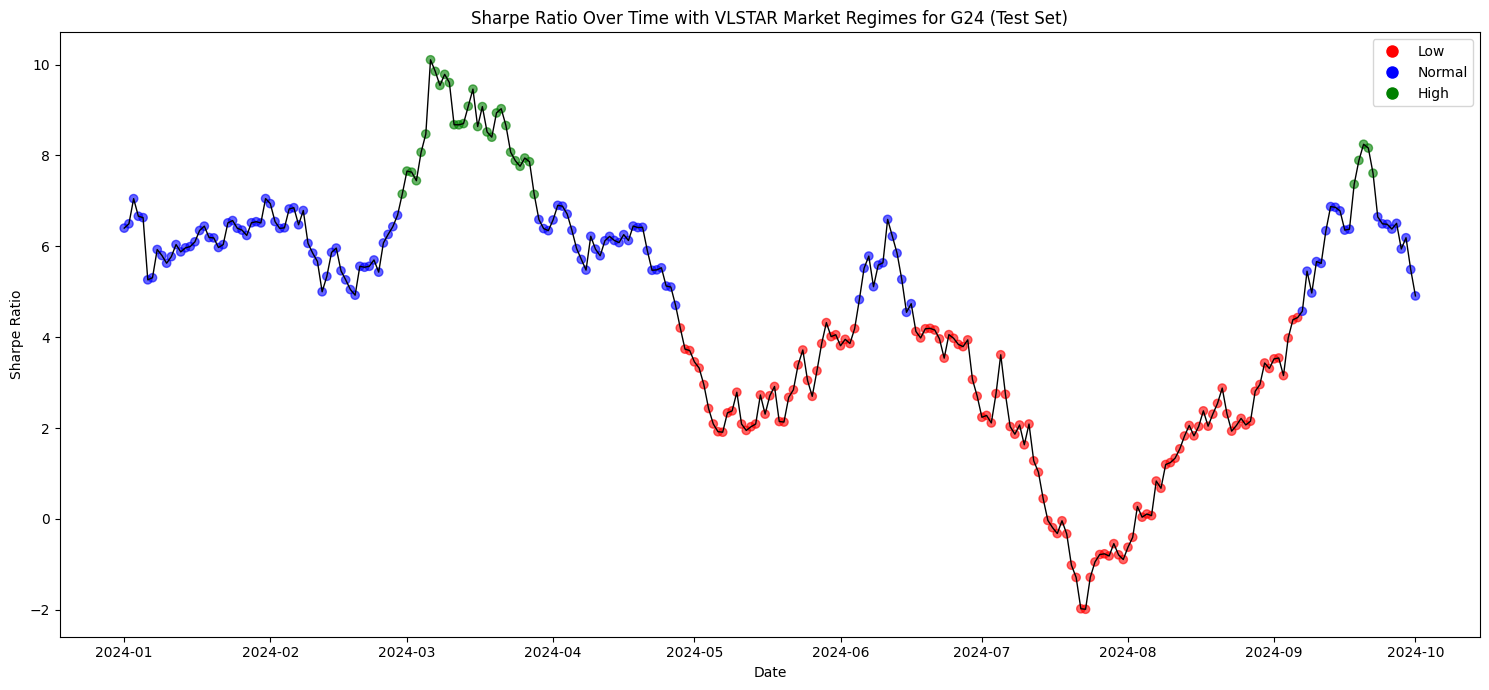

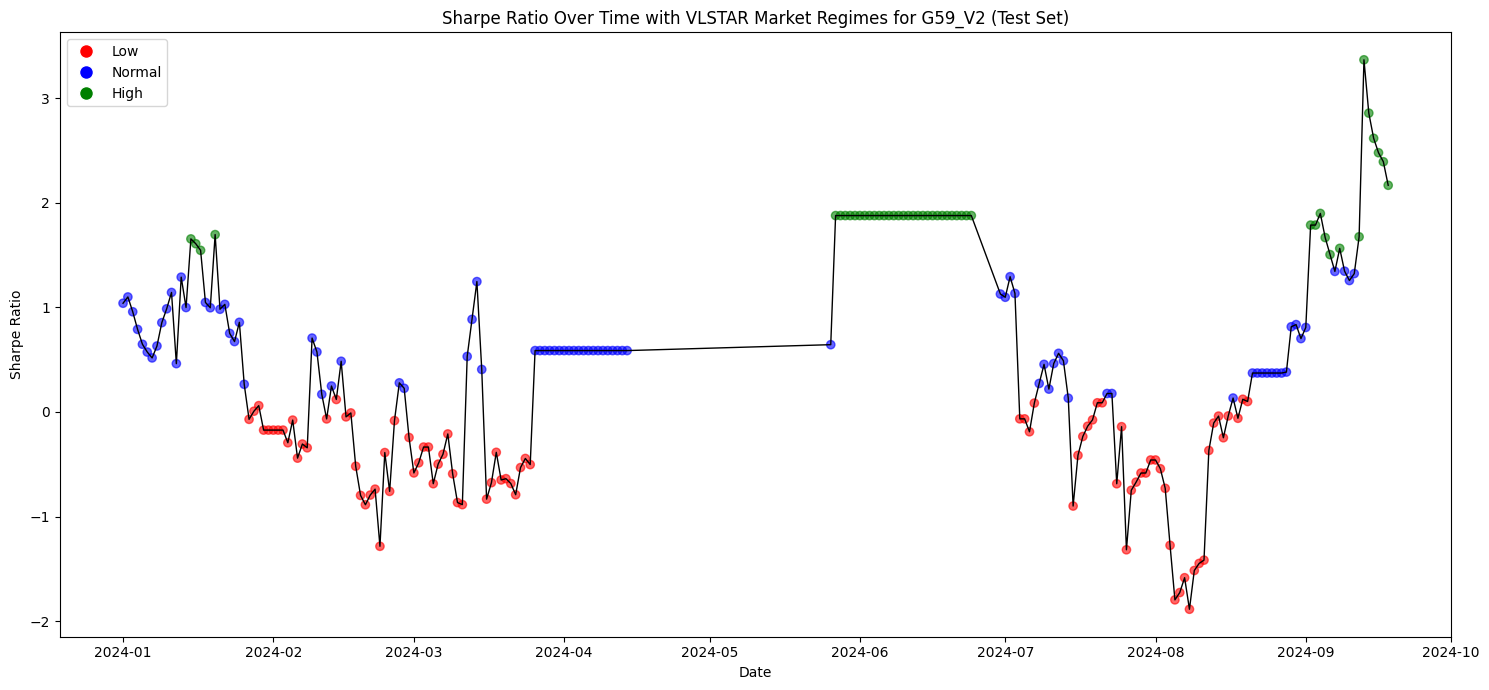

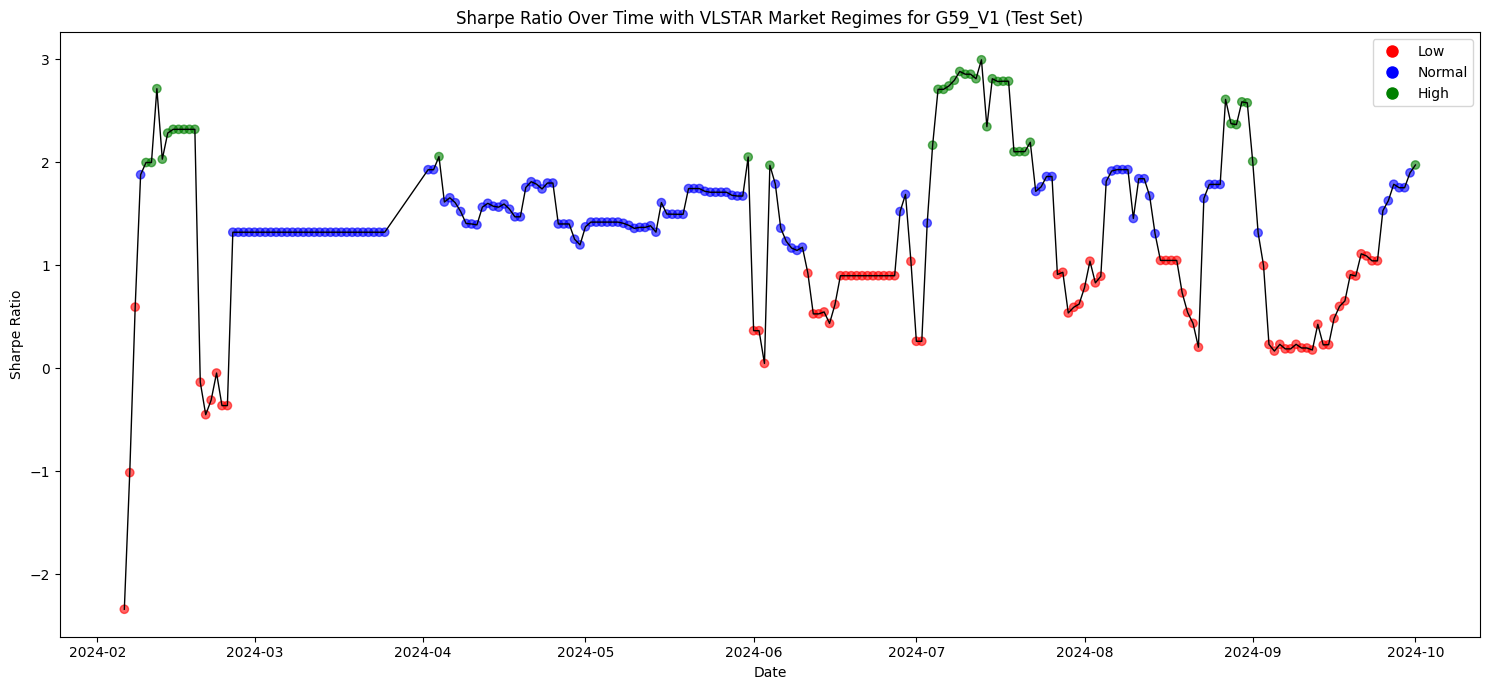

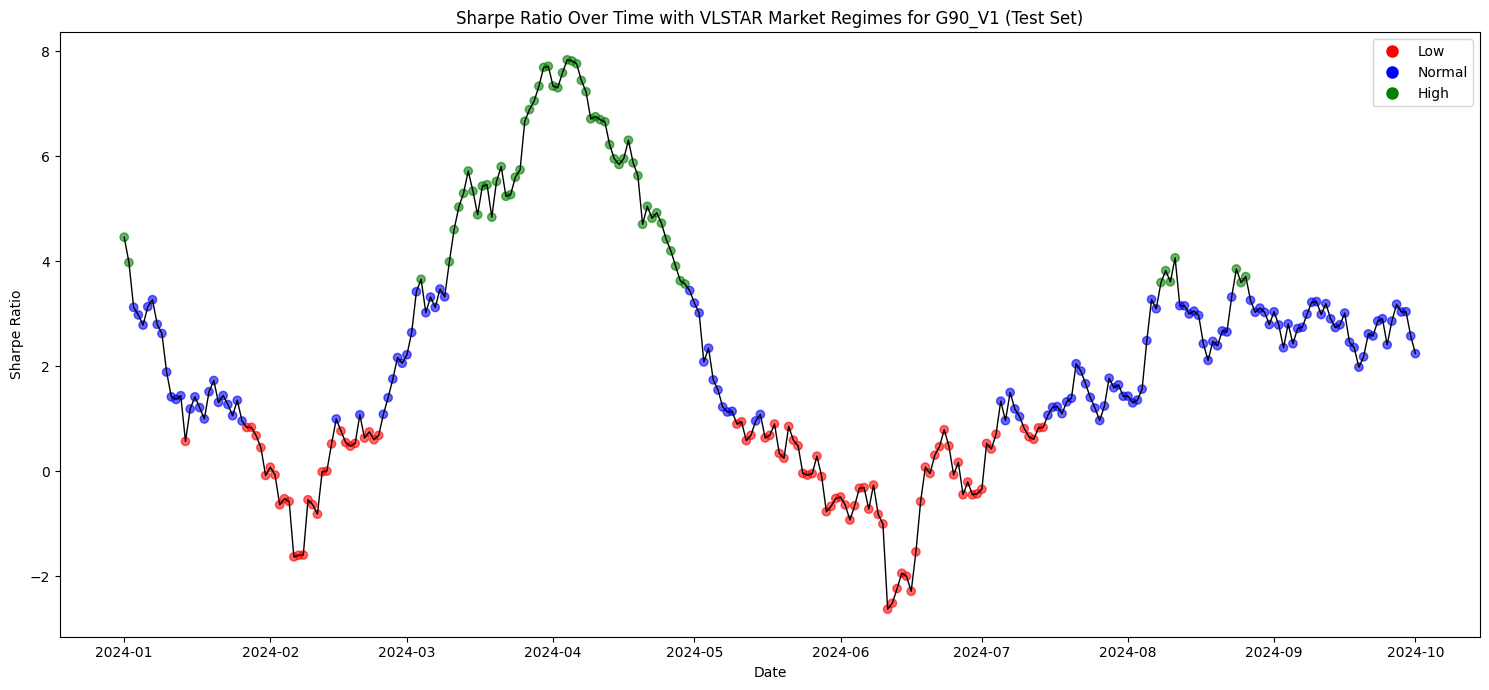

In [71]:
for strategy in strategy_names:
    visualize_regimes(test_data, vlstar_test_regime_labels, strategy, method_name='VLSTAR')

In [82]:
from hmmlearn import hmm
from hmmlearn.hmm import GaussianHMM

def fit_hmm(train_data, n_states=3, covariance_type='diag', n_iter=1000):
    hmm_models = {}
    
    for strategy in train_data.keys():
        X = train_data[strategy]['Sharpe_Ratio_60'].values.reshape(-1, 1)  # (n_samples, n_features)
        
        model = GaussianHMM(n_components=n_states, covariance_type=covariance_type, n_iter=n_iter, random_state=42)
        
        model.fit(X)
        
        hmm_models[strategy] = model
    
    return hmm_models

In [83]:
def predict_hmm_regimes(hmm_models, test_data):
    test_regime_labels = {}
    
    for strategy in test_data.keys():
        X_test = test_data[strategy]['Sharpe_Ratio_60'].values.reshape(-1, 1)  # (n_samples, n_features)
        
        model = hmm_models[strategy]
        
        hidden_states = model.predict(X_test)
        
        test_regime_labels[strategy] = hidden_states
    
    return test_regime_labels

In [84]:
def map_hmm_states_to_regimes(train_data, hmm_models, n_states=3, regime_labels=['Low', 'Normal', 'High']):
    regime_mapping_dict = {}
    
    for strategy in train_data.keys():
        X = train_data[strategy]['Sharpe_Ratio_60'].values.reshape(-1, 1)
        
        model = hmm_models[strategy]
        
        hidden_states = model.predict(X)
        
        state_means = []
        for state in range(n_states):
            state_mean = X[hidden_states == state].mean()
            state_means.append((state, state_mean))
        
        sorted_states = sorted(state_means, key=lambda x: x[1])
        
        state_to_regime = {}
        for i, (state, _) in enumerate(sorted_states):
            if i < len(regime_labels):
                state_to_regime[state] = regime_labels[i]
            else:
                state_to_regime[state] = f'Label_{state}'
        
        regime_mapping_dict[strategy] = state_to_regime
    
    return regime_mapping_dict

In [87]:
def assign_regime_labels(test_hidden_states, regime_mapping_dict, strategy_names):
    test_regime_labels = {}
    
    for strategy in strategy_names:
        hidden_states = test_hidden_states[strategy]
        
        state_to_regime = regime_mapping_dict[strategy]
        
        regime_labels = [state_to_regime.get(state, 'Noise') for state in hidden_states]
        
        test_regime_labels[strategy] = regime_labels
    
    return test_regime_labels


In [88]:
def visualize_hmm_regimes(test_data, test_regime_labels, regime_mapping_dict, strategy, method_name='HMM'):
    state_to_regime = regime_mapping_dict[strategy]
    regime_labels = [state_to_regime.get(state, 'Noise') for state in test_regime_labels[strategy]]
    
    test_regime_labels_qualitative = regime_labels
    
    test_regime_labels[strategy] = test_regime_labels_qualitative
    
    visualize_regimes(test_data, test_regime_labels, strategy, method_name=method_name)


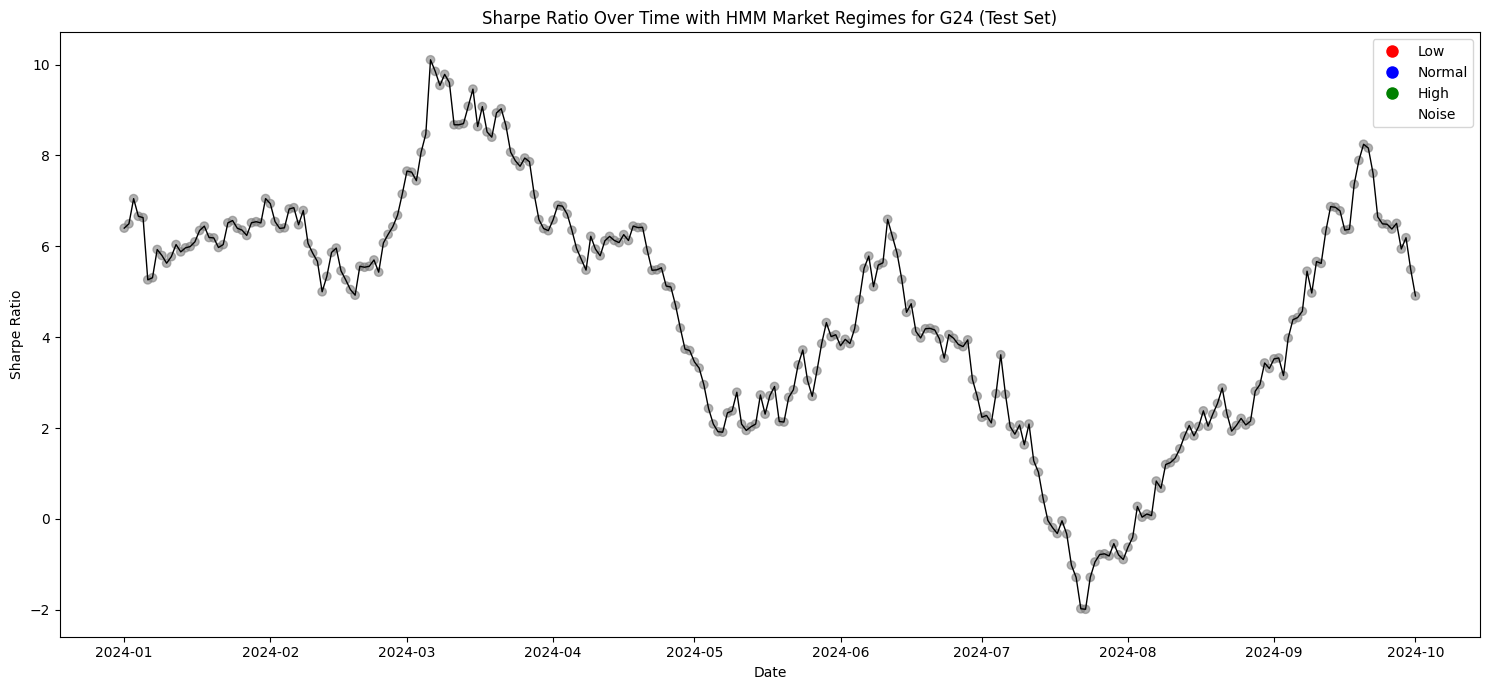

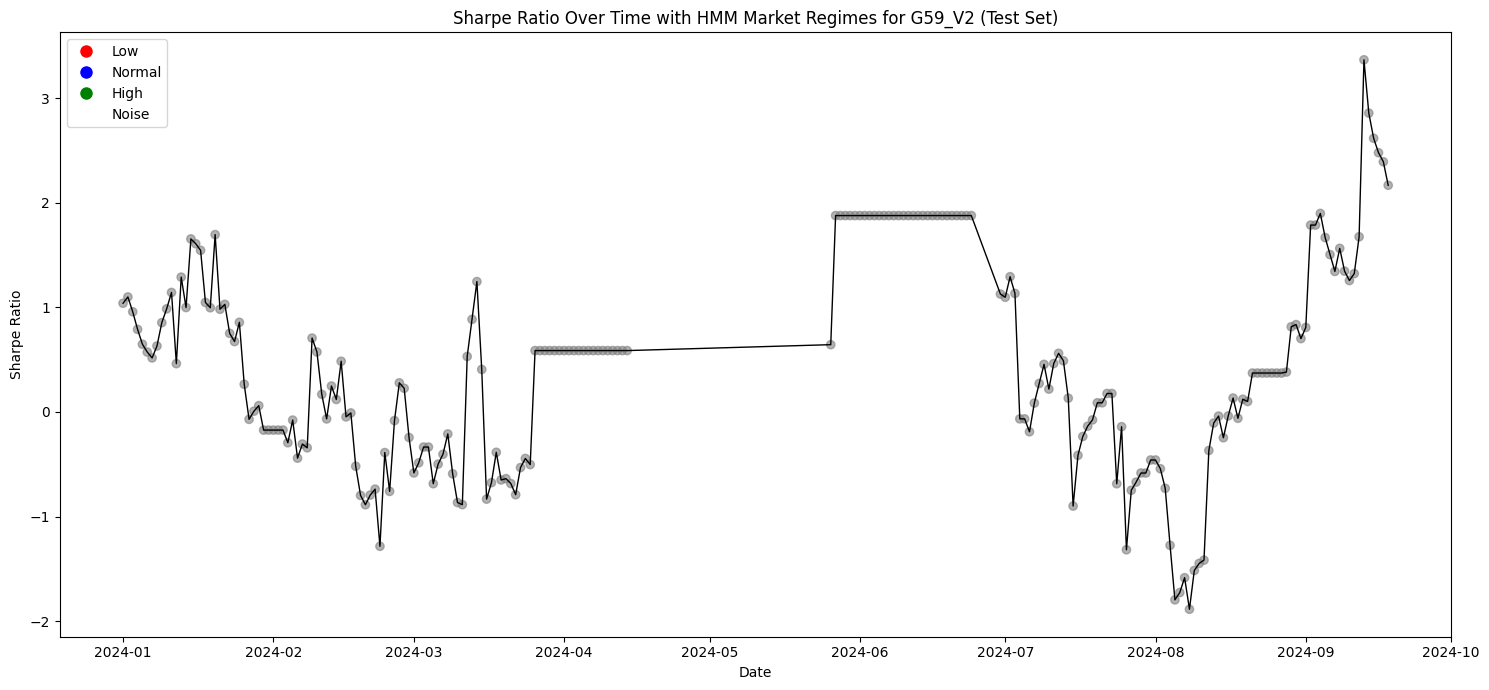

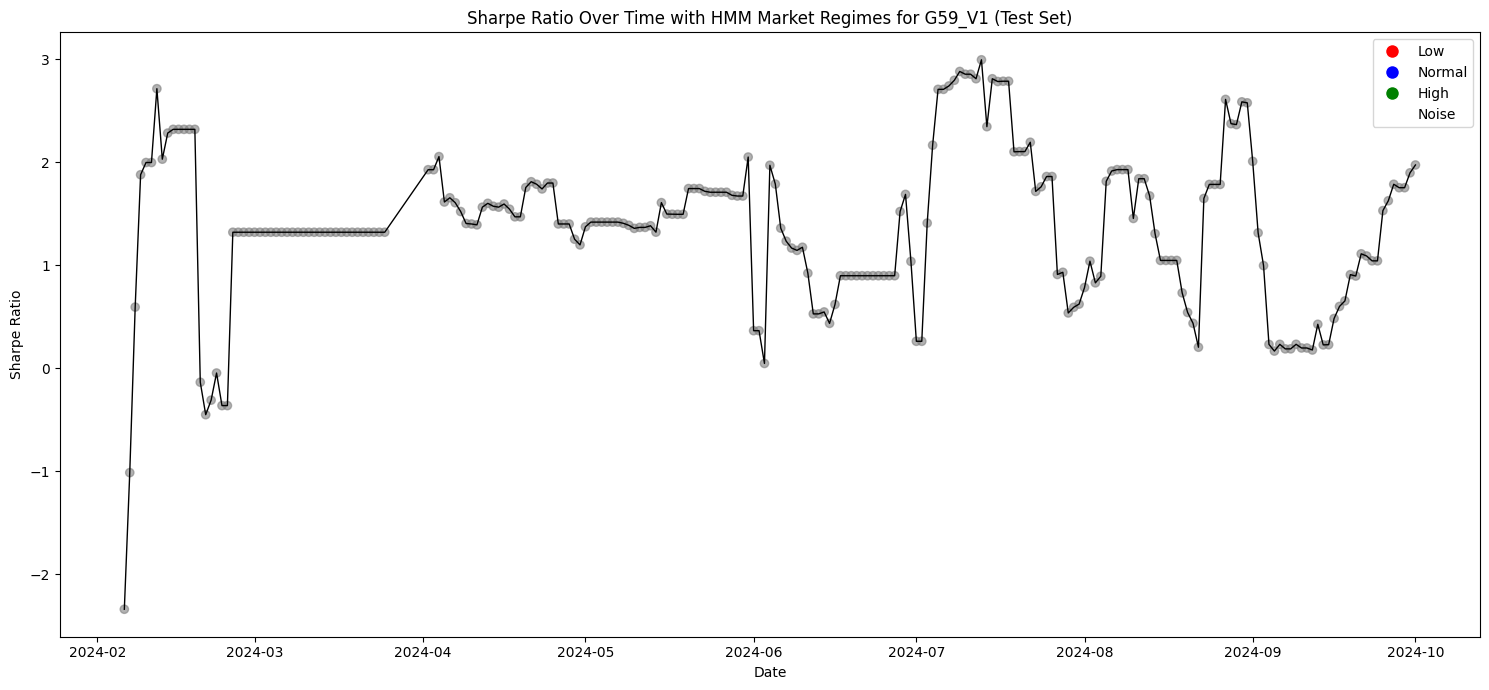

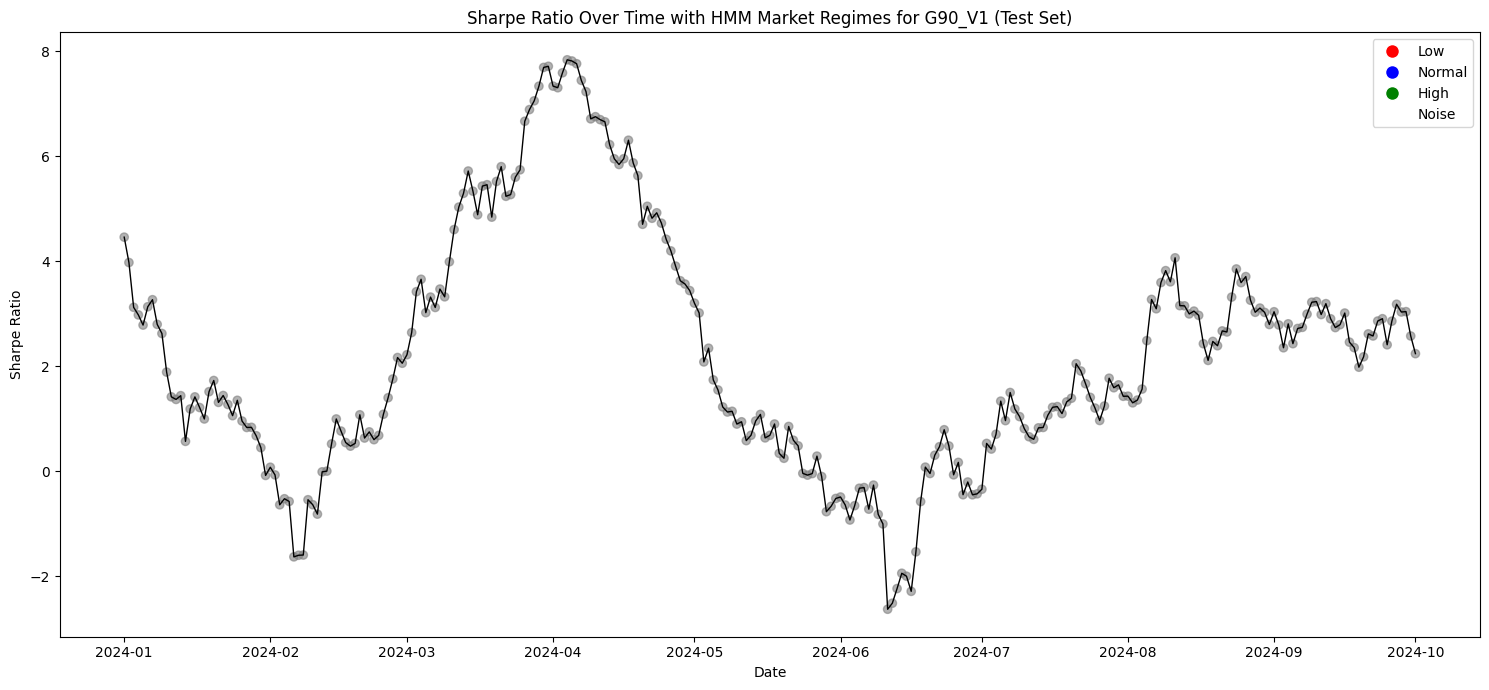

In [89]:
hmm_models = fit_hmm(
    train_data, 
    n_states=3,  
    covariance_type='diag', 
    n_iter=1000
)

regime_mapping_dict = map_hmm_states_to_regimes(
    train_data, 
    hmm_models, 
    n_states=3, 
    regime_labels=['Low', 'Normal', 'High']
)

test_hidden_states = predict_hmm_regimes(
    hmm_models, 
    test_data
)


test_regime_labels = assign_regime_labels(
    test_hidden_states, 
    regime_mapping_dict, 
    strategy_names=train_data.keys()
)


for strategy in train_data.keys():
    visualize_hmm_regimes(
        test_data, 
        test_regime_labels, 
        regime_mapping_dict, 
        strategy, 
        method_name='HMM'
    )